In [2]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,savefig

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra
from src.xrd_data import DataXRD

In [3]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [4]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [5]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [6]:
files = glob('Profilo/Lazurite/roi*.dat')
phase = MixPhase([barite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=32)
    
    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

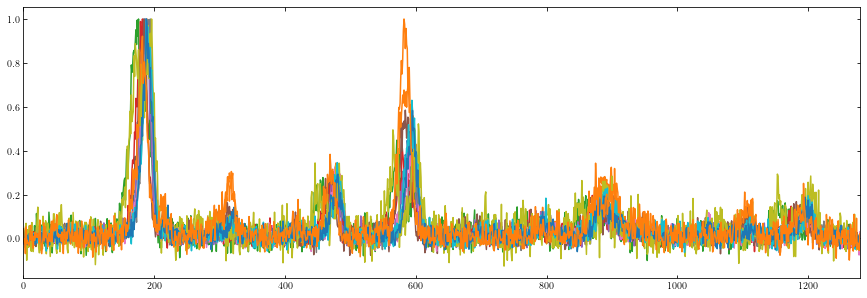

In [7]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1153.3122897042615, 50.99999999999994, 1860.9596634201016] 10.429925442558824
[-1159.810797338587, 51.00000000000012, 1871.6867912638197] 23.064784794134724
[-1166.1363722183225, 50.99999999999998, 1908.5559563881673] 11.845221793384967
[-1146.2604031432222, 51.00000000000001, 1859.5517530999878] 23.97778823982819
[-1146.3405645816088, 50.99999999999997, 1850.4368997419238] 30.11824854158073
[-1184.3055341448292, 51.00000000000009, 1930.2112442054233] 168.17188887162314
[-1170.392053128143, 51.00000000000019, 1890.9196276975106] 9.836668331237316
[-1163.2038073165838, 50.99999999999999, 1873.4296896175015] 4.025692558419757
[-1171.1655091855696, 50.99999999999993, 1881.872455899573] 14.928026631476822
[-1161.5099235630505, 51.000000000000014, 1872.1550239345074] 7.44279548616319
[-1174.8458346251914, 50.99999999999958, 1898.9174063511007] 10.622296489882578
[-1153.871162199645, 50.99999999999996, 1871.7587645497624] 36.39521619101716


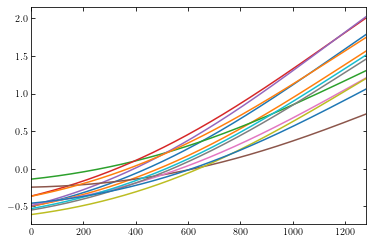

In [8]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
    
    for _ in range(32):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

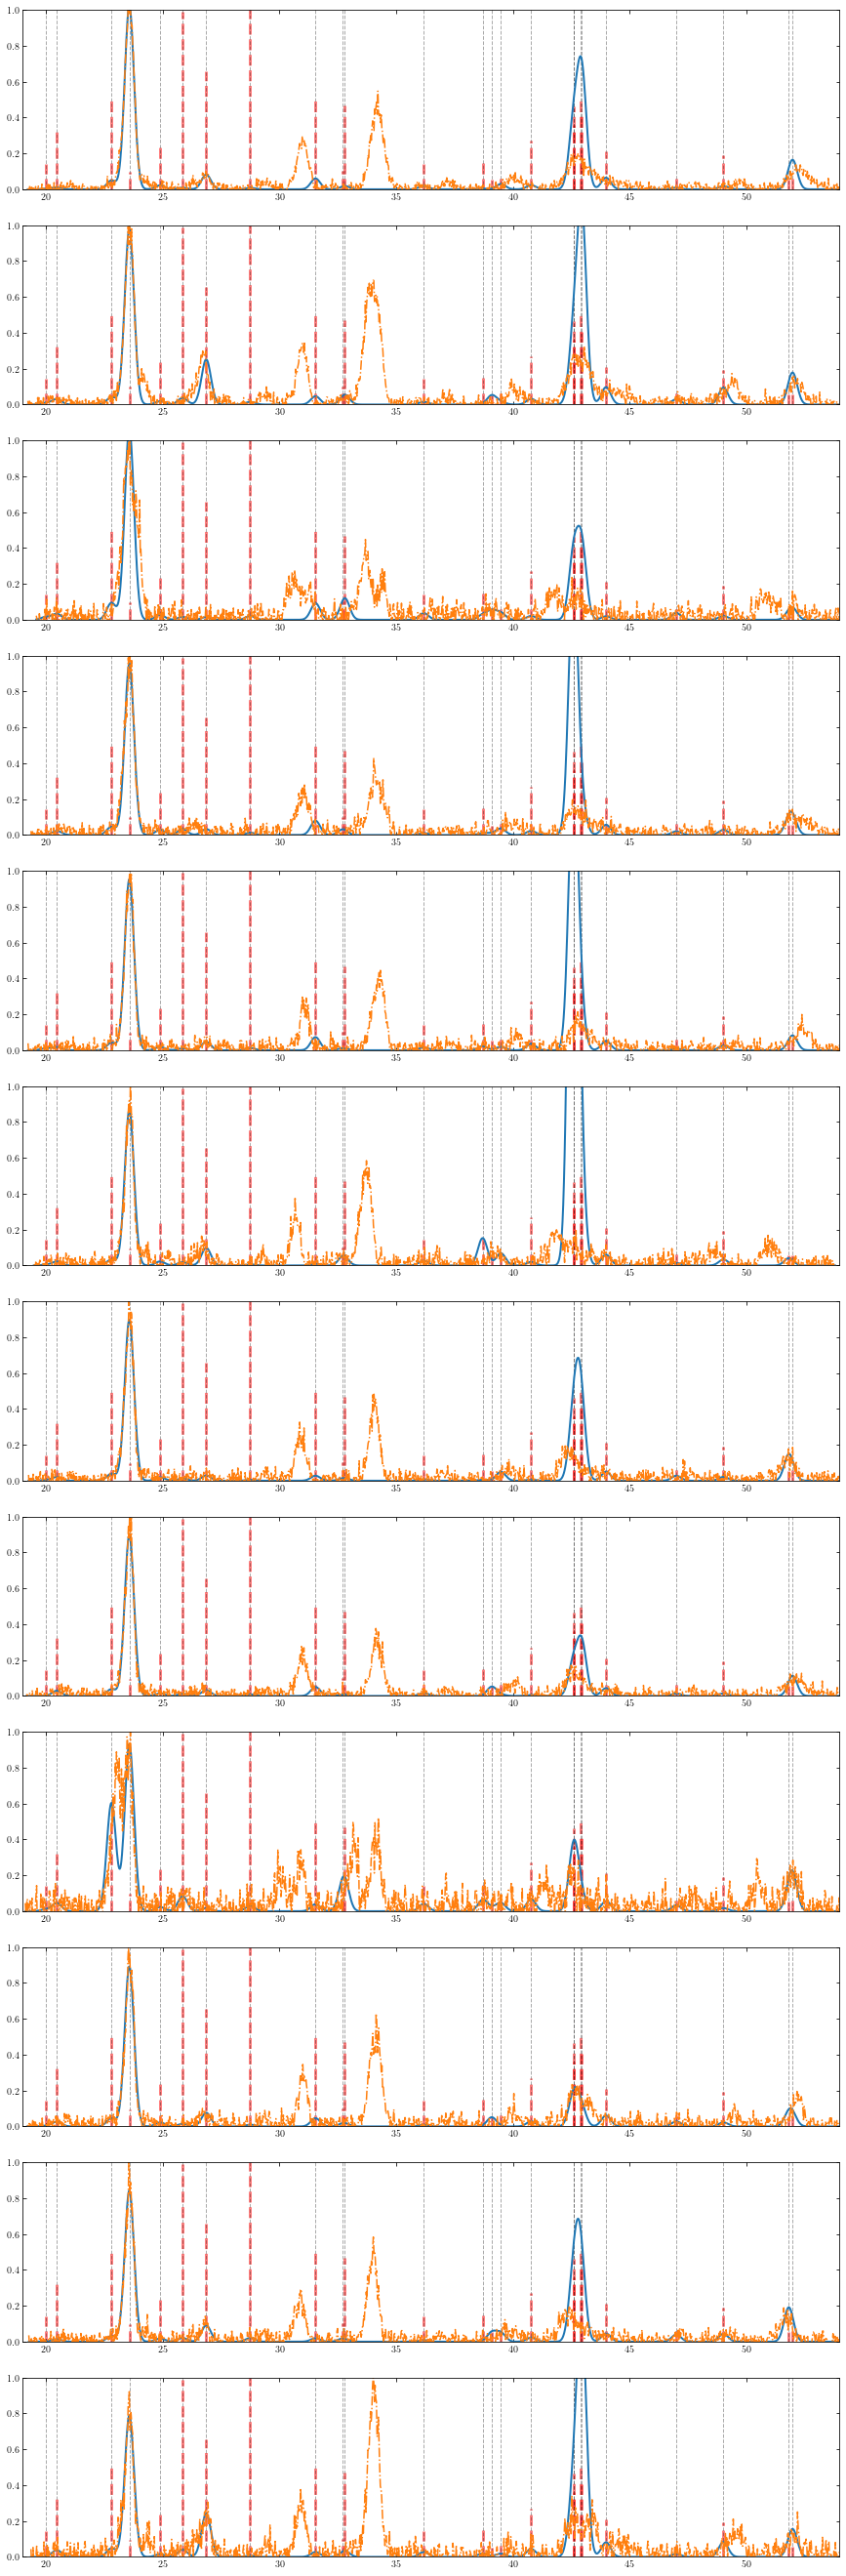

In [9]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,48))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [10]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    spectra.convolve(4).raw_snip(m=16)
    
    g = GaussNewton(phase,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 10min 24s, sys: 219 ms, total: 10min 24s
Wall time: 10min 24s


In [ ]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

In [10]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)

In [ ]:
f = (a > -1150)
out[f] *= 2

In [ ]:
f = (xrd_data.inverted[:,:,185] < 50)
out[f] = 100

In [ ]:
out.shape,xrd_data.inverted.shape

In [ ]:
out.max(),out.min()

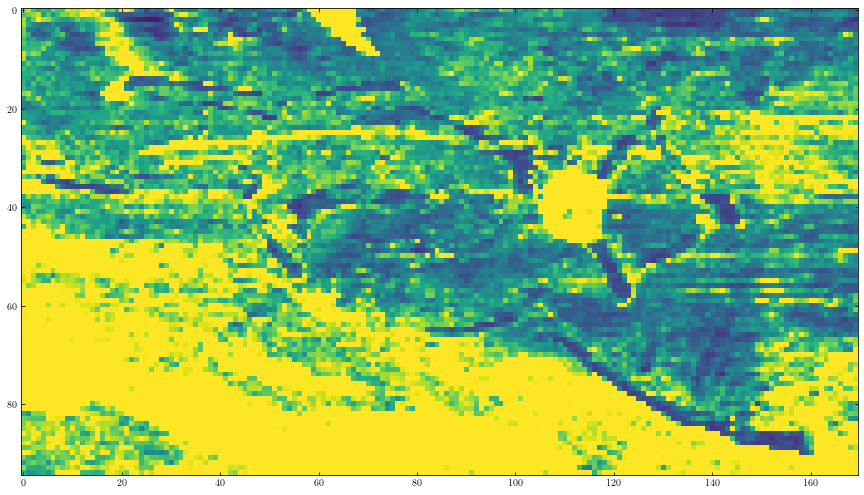

In [11]:
figure(figsize=(15,15))
imshow(out[::-1],vmin=0,vmax=6)
#savefig('Lazurite_loss.png')

In [ ]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(64):
    g.calibration_nobeta()
print(g.dz)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

In [ ]:
a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()

In [ ]:
%matplotlib inline
figure(figsize=(15,15))
imshow(a[::-1],vmin=-1200)

In [ ]:
imshow(xrd_data.inverted[:,:,185][::-1],vmin=50)